In [1]:
#This project has been worked in conjunction with the guidance found in the 
#Recording and Coding Guide for the Structure Inventory and Appraisal of the Nations Bridges on the FHWA website
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder as geo
current_year = 2017

## Import and clean data

In [30]:
filedata = pd.read_csv('GA17.txt')
#drop all culverts from the dataset, we only want to analyze bridges
data = filedata.loc[filedata['CULVERT_COND_062']=='N']
num_bridges, num_columns = data.shape

In [77]:
#Add age column for prediction
data['AGE'] = current_year - data['YEAR_BUILT_027']
#Collect columns of interest
column_list = ['LAT_016','LONG_017','YEAR_BUILT_027','AGE','STRUCTURE_LEN_MT_049','MAIN_UNIT_SPANS_045','MAX_SPAN_LEN_MT_048','ROADWAY_WIDTH_MT_051','DECK_WIDTH_MT_052','CAT29','ADT_029','YEAR_ADT_030','PERCENT_ADT_TRUCK_109','DEGREES_SKEW_034','DESIGN_LOAD_031','OPERATING_RATING_064','INVENTORY_RATING_066','MIN_VERT_CLR_010','HORR_CLR_MT_047','WATERWAY_EVAL_071','DECK_COND_058','SUPERSTRUCTURE_COND_059','SUBSTRUCTURE_COND_060','SUFFICIENCY_RATING']
#Check dataset for null values and convert all columns to numeric values
for column in column_list:
    data[column] = pd.to_numeric(data[column],errors='coerce')
    print(column,':',data[column].isnull().any())
#The last 4 columns are the variables to be predicted
feature_list = column_list[:-4]
df_features = data[feature_list]
print('')
print('Number of Bridges in Georgia (2017):',num_bridges)
print('Number of Dataset Columns:',num_columns)
print('Number of Features:',len(feature_list))
data = data[data['YEAR_BUILT_027']>1900]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


LAT_016 : False
LONG_017 : False
YEAR_BUILT_027 : False
AGE : False
STRUCTURE_LEN_MT_049 : False
MAIN_UNIT_SPANS_045 : False
MAX_SPAN_LEN_MT_048 : False
ROADWAY_WIDTH_MT_051 : False
DECK_WIDTH_MT_052 : False
CAT29 : False
ADT_029 : False
YEAR_ADT_030 : False
PERCENT_ADT_TRUCK_109 : True
DEGREES_SKEW_034 : False
DESIGN_LOAD_031 : True
OPERATING_RATING_064 : True
INVENTORY_RATING_066 : True
MIN_VERT_CLR_010 : False
HORR_CLR_MT_047 : False
WATERWAY_EVAL_071 : True
DECK_COND_058 : True
SUPERSTRUCTURE_COND_059 : True
SUBSTRUCTURE_COND_060 : False
SUFFICIENCY_RATING : False

Number of Bridges in Georgia (2017): 9198
Number of Dataset Columns: 137
Number of Features: 20


Interestingly, the GDOT website says that there are 14,750 bridges in Georgia as of 2018. There definition must include culverts to some extent.

We have excluded bridges built before ASTM standards were in place, to normalize the data, because
bridges built before then would have had inconsistent standards for material acceptance in the bridge.
ASTM was officially founded in 1898, so if we choose a cutoff of 1900 to allow for adoption of the standard.

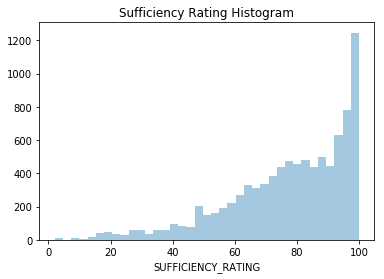

In [79]:
#data['SUFFICIENCY_RATING'].plot(kind='hist',bins=20)
sns.distplot(data['SUFFICIENCY_RATING'],kde=False)
plt.title('Sufficiency Rating Histogram')
plt.show()

In [7]:
perc_atorbelow_50 = data['SUFFICIENCY_RATING'].loc[data['SUFFICIENCY_RATING']<=50].shape[0] / num_bridges *100
perc_atorbelow_80 = data['SUFFICIENCY_RATING'].loc[data['SUFFICIENCY_RATING']<=80].shape[0] / num_bridges *100
perc_above_80 = 100-perc_atorbelow_80
print(perc_atorbelow_50)
print(perc_atorbelow_80)
print(perc_above_80)

10.697977821265493
48.043052837573384
51.956947162426616


In [8]:
data['YEAR_BUILT_027'].describe()

count    9198.000000
mean     1975.618069
std        21.395724
min      1872.000000
25%      1961.000000
50%      1975.000000
75%      1992.000000
max      2017.000000
Name: YEAR_BUILT_027, dtype: float64

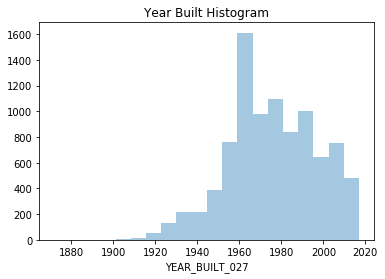

In [75]:
sns.distplot(data['YEAR_BUILT_027'],kde=False,bins=20)
plt.title('Year Built Histogram')
plt.show()

Looks like there was a spike of bridges built in the 1960s. This corresponds to passing of the Federal-Aid Highway Act of 1956 by President Eisenhower
https://www.fhwa.dot.gov/infrastructure/50interstate.cfm

In [10]:
data.AGE.describe()

count    9198.000000
mean       41.381931
std        21.395724
min         0.000000
25%        25.000000
50%        42.000000
75%        56.000000
max       145.000000
Name: AGE, dtype: float64

145 years old! Let's all agree to never drive over that bridge in the future. Let's see the relationship between age and sufficiency rating

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


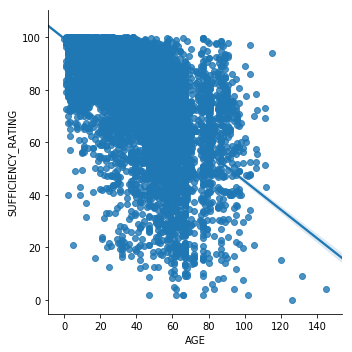

In [11]:
sns.lmplot(x='AGE',y='SUFFICIENCY_RATING',data=data)
plt.show()

Not much information here, other than a weaker relationship than I originally thought. We will group by year and take the average sufficiency rating, then visualize.

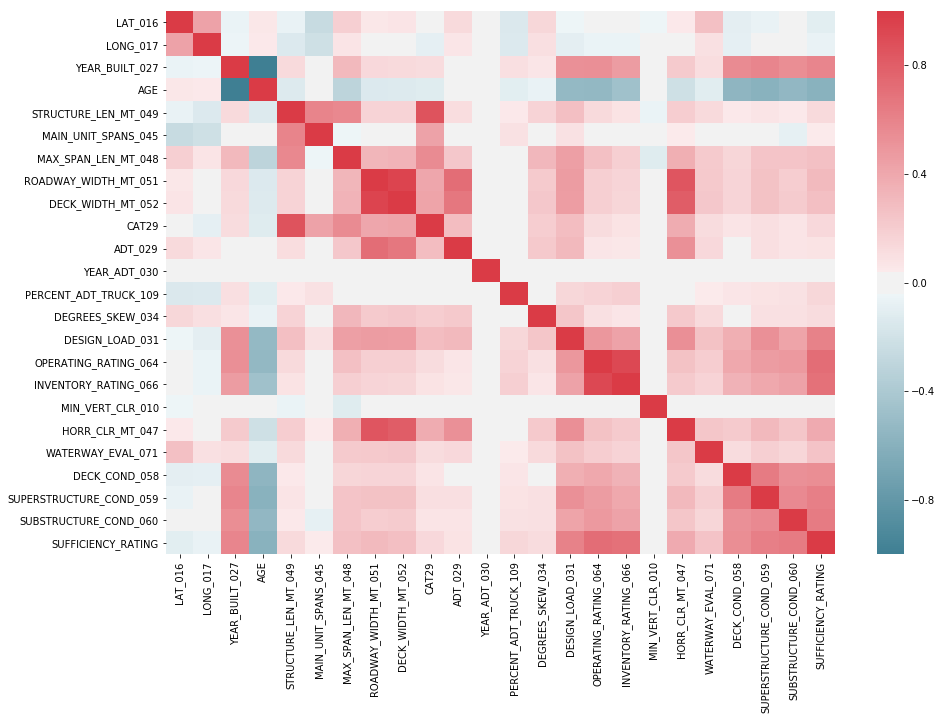

In [70]:
#sns.pairplot(data[column_list])
heat = data[column_list].corr()
fig, ax = plt.subplots(figsize=(15, 10))
colormap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(heat, cmap=colormap, annot=False, fmt=".2f")
plt.show()

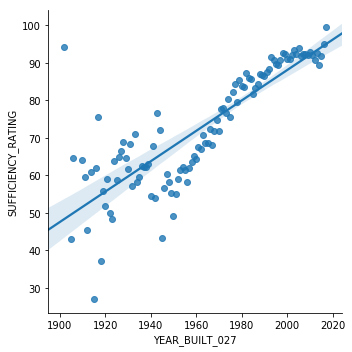

In [78]:
suff_data = data.groupby('YEAR_BUILT_027').mean()['SUFFICIENCY_RATING']
suff_data = suff_data.reset_index()
sns.lmplot(x='YEAR_BUILT_027',y='SUFFICIENCY_RATING',data=suff_data)

In [15]:
#location = geo.google('Atlanta, GA')
#location.latlng